In [150]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
pth_b_w = './data/day.csv'
bicycles_raw = pd.read_csv(pth_b_w)

In [152]:
BICYCLES = bicycles_raw.drop(columns=["dteday", "yr", "instant", "weekday", "casual", "registered", "atemp", "mnth"])
BICYCLES["season"] = BICYCLES["season"].replace({1: "Зима", 2: "Весна", 3: "Лето", 4: "Осень"})
BICYCLES["holiday"] = BICYCLES["holiday"].replace({0:"Нет", 1: "Да"})
BICYCLES["workingday"] = BICYCLES["workingday"].replace({0:"Нет", 1: "Да"})
BICYCLES["weathersit"] = BICYCLES["weathersit"].replace({1:"Ясная", 2: "Облачная", 3: "Пасмурная"})
BICYCLES.head()

,season,holiday,workingday,weathersit,temp,hum,windspeed,cnt
0,Зима,Нет,Нет,Облачная,14.110847,80.5833,10.749882,985
1,Зима,Нет,Нет,Облачная,14.902598,69.6087,16.652113,801
2,Зима,Нет,Да,Ясная,8.050924,43.7273,16.636703,1349
3,Зима,Нет,Да,Ясная,8.200000,59.0435,10.739832,1562
4,Зима,Нет,Да,Ясная,9.305237,43.6957,12.522300,1600


In [153]:
BICYCLES.select_dtypes("object")

,season,holiday,workingday,weathersit
0,Зима,Нет,Нет,Облачная
1,Зима,Нет,Нет,Облачная
2,Зима,Нет,Да,Ясная
3,Зима,Нет,Да,Ясная
4,Зима,Нет,Да,Ясная
...,...,...,...,...
725,Зима,Нет,Да,Облачная
726,Зима,Нет,Да,Облачная
727,Зима,Нет,Нет,Облачная
728,Зима,Нет,Нет,Ясная


In [154]:
BICYCLES.astype({"season" :'category', "holiday":'category', "workingday":'category',
                 "weathersit":'category', "temp": np.float64, "windspeed": np.float64, "cnt": np.int64})
BA = BICYCLES.select_dtypes(include=["int", "float"])
BA_STAT = BA.describe()
W = BA.quantile(q=0.75) - BA.quantile(q=0.25) # Получается pandas.Series
# Создаем pandas.DataFrame из новых статистик
BA_irq = pd.DataFrame([W], index=['IQR'])
# Объединяем CA_STAT и W
CA_STAT = pd.concat([BA_STAT, BA_irq])
CA_STAT


,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620,4508.006849
std,7.506729,14.237589,5.195841,1936.011647
min,2.424346,0.000000,1.500244,22.000000
25%,13.811885,52.000000,9.041650,3169.750000
50%,20.465826,62.625000,12.125325,4548.500000
75%,26.880615,72.989575,15.625589,5966.000000
max,35.328347,97.250000,34.000021,8714.000000
IQR,13.068729,20.989575,6.583939,2796.250000


In [155]:
irq = BA_irq['cnt']
wisker_u = (CA_STAT.loc['75%', 'cnt'] + 1.5*irq).values[0]
wisker_l = (CA_STAT.loc['25%', 'cnt'] - 1.5*irq).values[0]
sel = (BA['cnt'] > wisker_u) + (BA['cnt'] <= wisker_l)
OUT = BA.loc[sel, :]
print(len(OUT))


0


In [156]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Здесь будут значения оценок коэффициента корреляции Пирсона
C_P = pd.DataFrame([], index=BA.columns, columns=BA.columns) 
# Здесь будут значения значимости оценок коэффициента корреляции Пирсона
P_P = pd.DataFrame([], index=BA.columns, columns=BA.columns)
# Здесь будут значения оценок коэффициента корреляции Спирмена
C_S = pd.DataFrame([], index=BA.columns, columns=BA.columns)
# Здесь будут значения значимости оценок коэффициента корреляции Спирмена
P_S = pd.DataFrame([], index=BA.columns, columns=BA.columns)
for x in BA.columns:
    for y in BA.columns:
        C_P.loc[x,y], P_P.loc[x,y] = pearsonr(BA[x], BA[y])
        C_S.loc[x,y], P_S.loc[x,y] = spearmanr(BA[x], BA[y])

In [157]:
with pd.ExcelWriter('./output/BICYCLES_STAT.xlsx', engine="openpyxl") as wrt:
# Общая статистика
    BA_STAT.to_excel(wrt, sheet_name='stat')
# Корреляция Пирсона
    C_P.to_excel(wrt, sheet_name='Pearson')
    dr = C_P.shape[0] + 2
    P_P.to_excel(wrt, startrow=dr, sheet_name='Pearson') # Значимость
# Корреляция Спирмена
    C_S.to_excel(wrt, sheet_name='Spirmen')
    dr = C_S.shape[0] + 2
    P_S.to_excel(wrt, startrow=dr, sheet_name='Spirmen') # Значимость


In [158]:

from scipy.stats import kruskal

def make_cruskal(cat_name, stream):
      vals = BICYCLES[cat_name].unique()
      x_s= []
      for val in vals:
            val_true = BICYCLES[cat_name]== val
            x_s.append(BICYCLES.loc[val_true, 'cnt'])
      # Используем криетрий Крускала-Уоллиса
      Price_sig = kruskal(*x_s)
      # Сохраняем текстовый отчет
      with open('./output/BICYCLES_STAT.txt', 'a') as fln:
            print(f'Критерий Крускала-Уоллиса для переменных \'cnt\' и \'{cat_name}\'',
                  file=stream)
            print(Price_sig, file=stream)

bicycles_n = BICYCLES.select_dtypes(include=["object"])

with open('./output/BICYCLES_STAT.txt', 'w') as fln:
      for cat_name in bicycles_n.columns:
            make_cruskal(cat_name, fln)

In [159]:
import statsmodels.api as sm
from itertools import combinations


for left, right in combinations(bicycles_n.columns, 2):
    crtx = pd.crosstab(BICYCLES[left], BICYCLES[right], margins=True)
    crtx.columns.name = right
    crtx.index.name = left + '\\' +right
    tabx = sm.stats.Table(crtx)
    with pd.ExcelWriter('./output/BICYCLES_STAT.xlsx', engine="openpyxl", 
                    if_sheet_exists='overlay', mode='a') as wrt:
# Таблица сопряженности
        tabx.table_orig.to_excel(wrt, sheet_name=left + '-' + right) 
        dr = tabx.table_orig.shape[0] + 2 # Смещение по строкам
# Ожидаемые частоты при независимости
        tabx.fittedvalues.to_excel(wrt, sheet_name=left + '-' + right, startrow=dr) 
        
    with open('./output/BICYCLES_STAT.txt', 'a') as fln:
        resx = tabx.test_nominal_association()   
        nr = tabx.table_orig.shape[0]
        nc = tabx.table_orig.shape[1]
        N = tabx.table_orig.iloc[nr-1, nc-1]
        hisq = resx.statistic
        CrV = np.sqrt(hisq/(N*min((nr - 1, nc - 1))))
        print(f'Критерий HI^2 для переменных \'{left}\' и \'{right}\'',
          file=fln)
        print(resx, file=fln)
        print(f'Статистика Cramer V для переменных \'{left}\' и \'{right}\'',
          file=fln)
        print(CrV, file=fln)

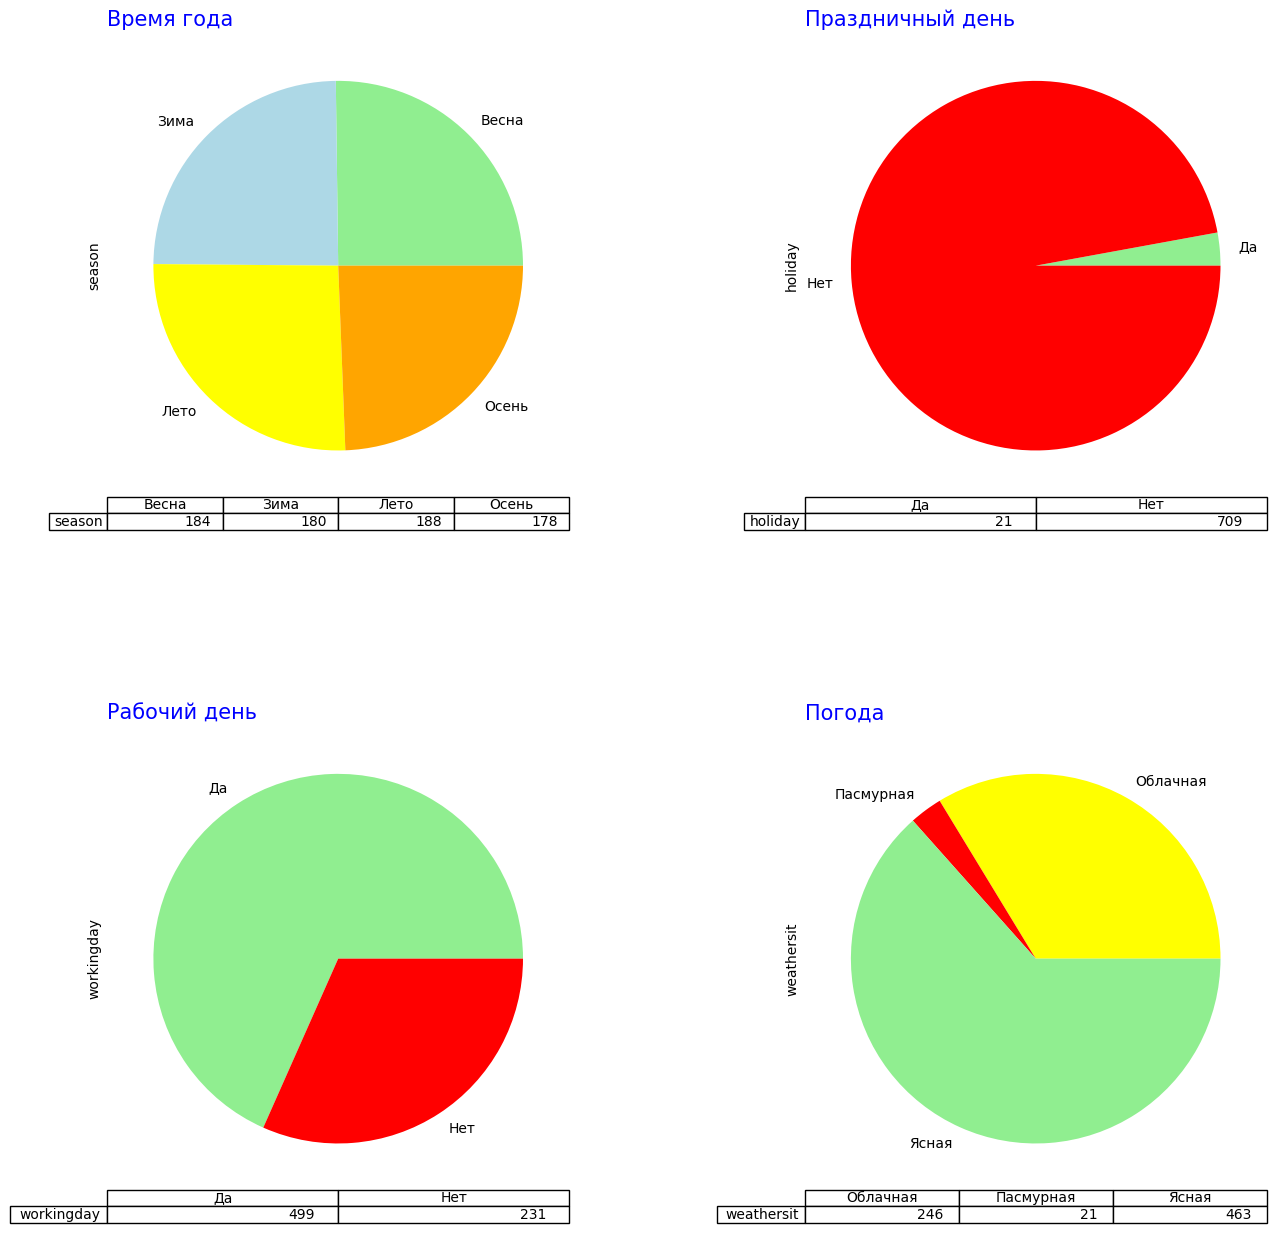

In [167]:
bicycles_n = BICYCLES.select_dtypes(include=["object"])
plt.figure(figsize=(15, 15)) # Дюймы
plt.subplots_adjust(wspace=0.5, hspace=0.5)
nplt = 0
nrow = bicycles_n.shape[1]//2
ncol = nrow
tit = {'season': "Время года", "weathersit":"Погода", "holiday": "Праздничный день", "workingday": "Рабочий день",
       "temp": "Темепература воздуха", "hum": "Относительная влажность воздуха", "windspeed": "Скорость ветра", "cnt": "Количество поездок"}
cat_colors = {
    'workingday': ['#90EE90','red'],
    'holiday': ['#90EE90','red'],
    'weathersit': ['yellow', 'red', '#90EE90'],
    'season': ['#90EE90','#ADD8E6', 'yellow', 'orange'],
}
for nplt, s in enumerate(bicycles_n.columns):
    ax = plt.subplot(nrow, ncol, nplt + 1)
    ftb = pd.crosstab(bicycles_n[s], s)
    ftb.index.name = 'Категории'
    ftb.plot.pie(subplots=True, table=True, ax=ax, grid=True, legend=False, 
                 colors=cat_colors[s])
    ax.set_title(tit[s], fontdict={'fontsize':15, 'color':'blue'}, loc='left')
plt.savefig('./graphics/bicycles_nom.pdf', format='pdf')

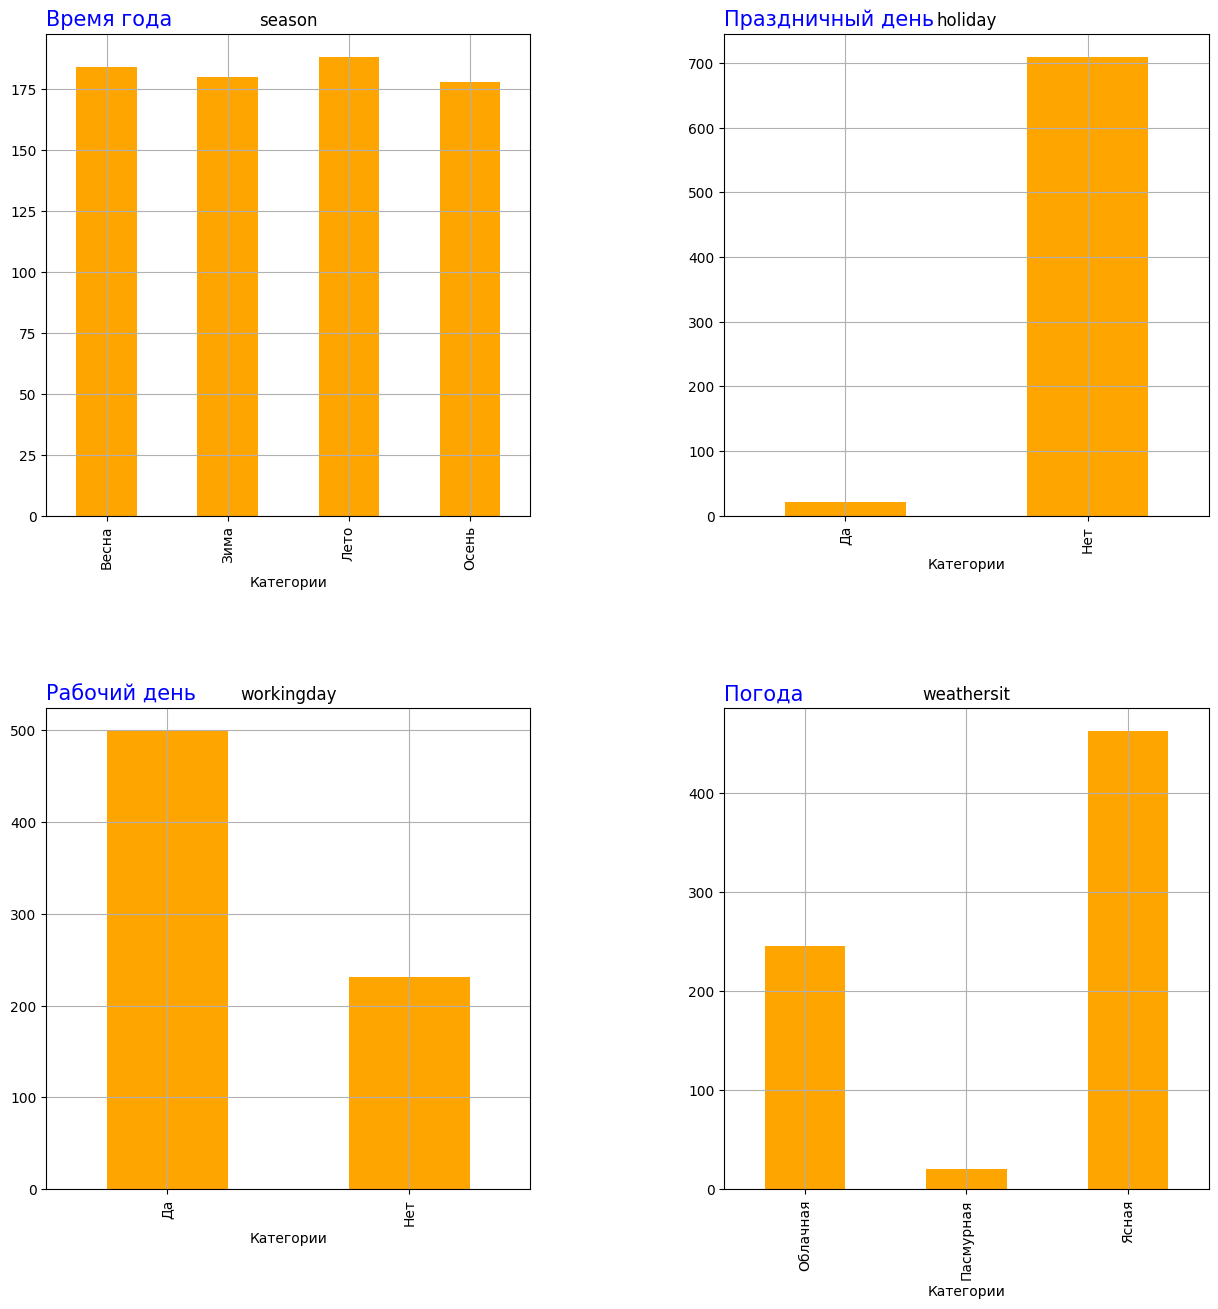

In [161]:
bicycles_n = BICYCLES.select_dtypes(include=["object"])
plt.figure(figsize=(15, 15)) # Дюймы
plt.subplots_adjust(wspace=0.4, hspace=0.4)
nplt = 0
nrow = bicycles_n.shape[1]//2
ncol = nrow
tit = {'season': "Время года", "weathersit":"Погода", "holiday": "Праздничный день", "workingday": "Рабочий день",
       "temp": "Темепература воздуха", "hum": "Относительная влажность воздуха", "windspeed": "Скорость ветра", "cnt": "Количество поездок"}
for nplt, s in enumerate(bicycles_n.columns):
    ax = plt.subplot(nrow, ncol, nplt + 1)
    ftb = pd.crosstab(bicycles_n[s], s)
    ftb.index.name = 'Категории'
    ftb.plot.bar(subplots=True, ax=ax, grid=True, legend=False, 
                 color="orange")
    ax.set_title(tit[s], fontdict={'fontsize':15, 'color':'blue'}, loc='left')
plt.savefig('./graphics/bicycles_bar.pdf', format='pdf')

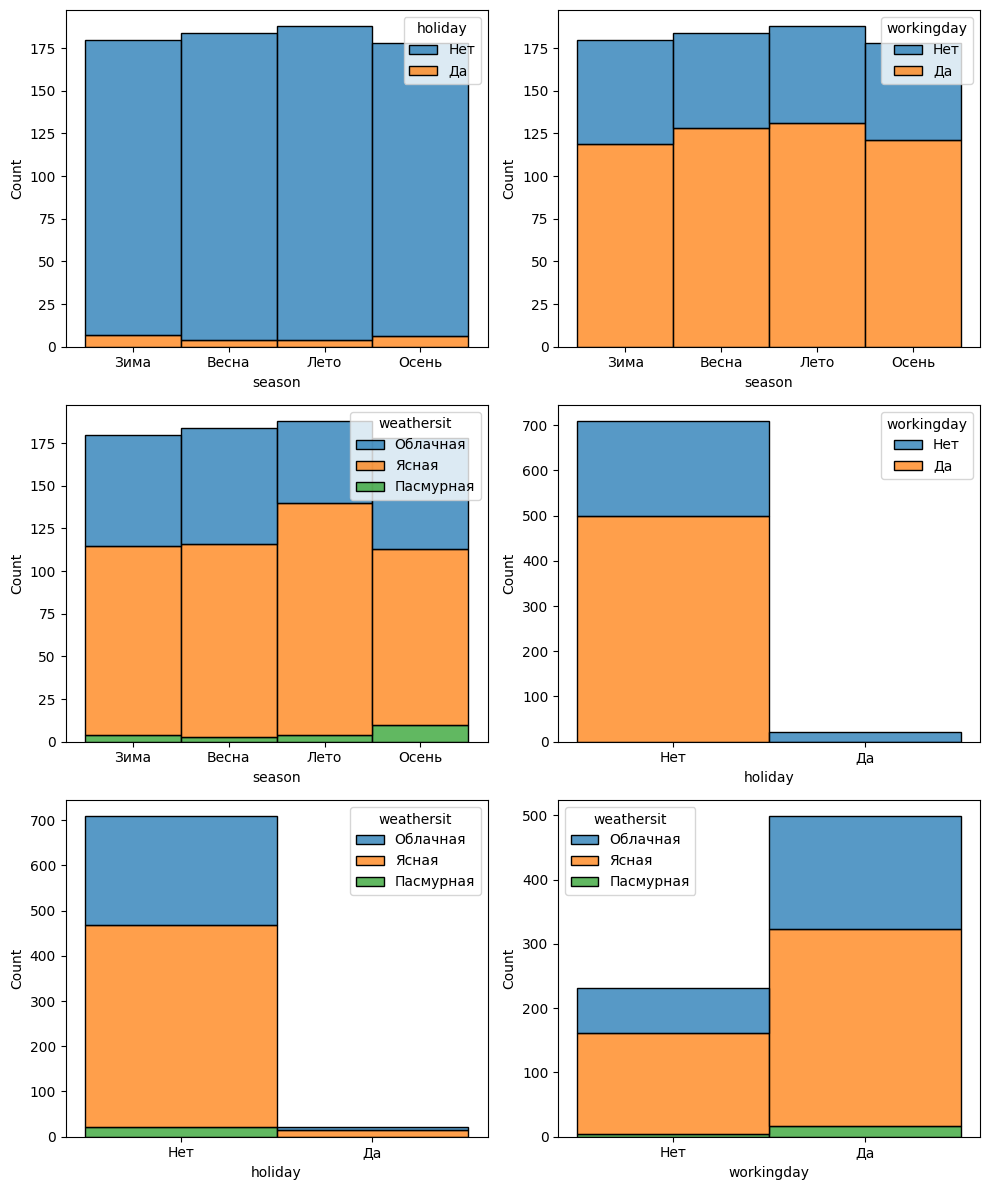

In [166]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 12))
for i, (left, right) in enumerate(combinations(bicycles_n.columns, 2)):
    sns.histplot(data=BICYCLES, x=left, hue=right, ax=axes[i//2][i%2], multiple="stack")
plt.tight_layout()
plt.savefig('./graphics/bicycles_combo.pdf', format='pdf')
plt.show()

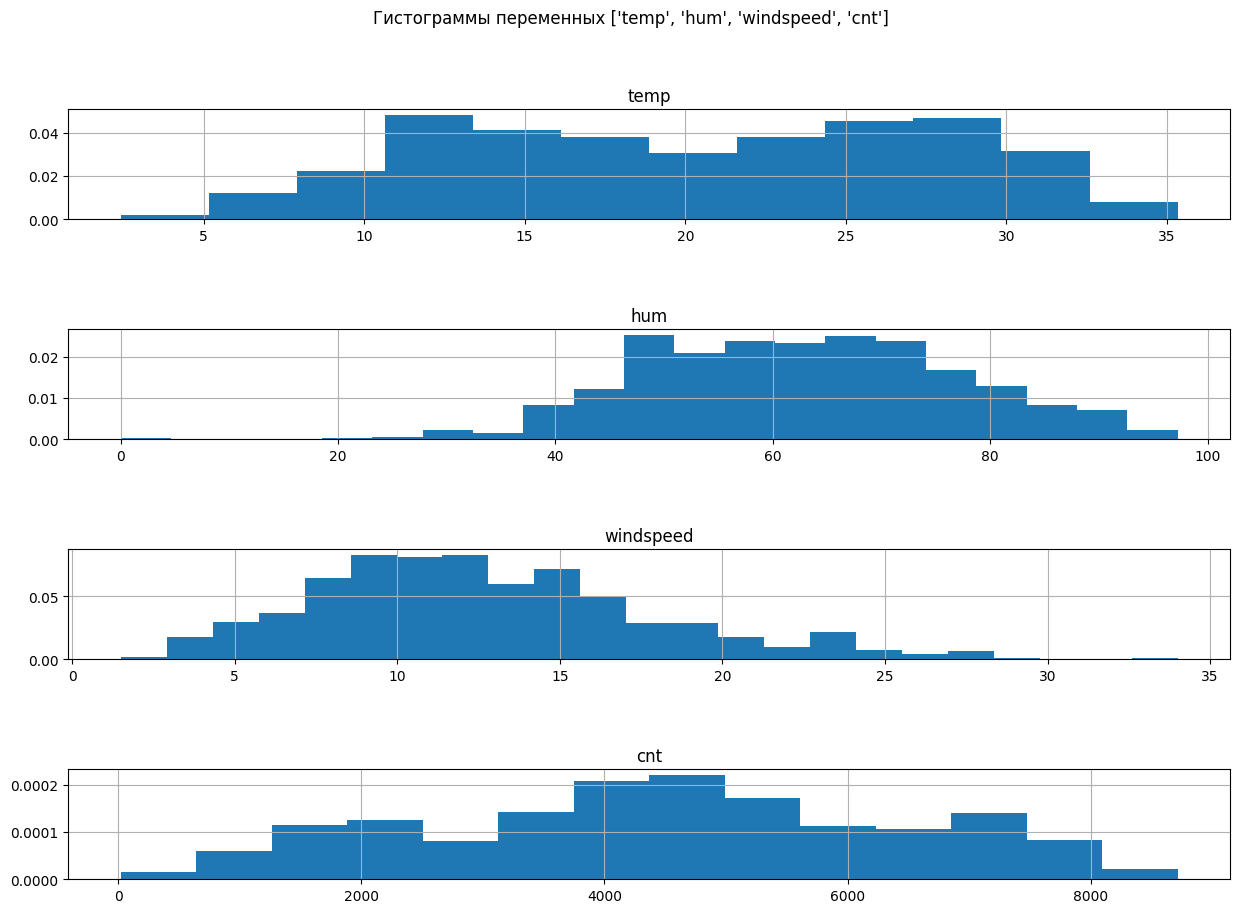

In [163]:
bicycles_rel = BICYCLES.select_dtypes(include=['float64', "int64"])
# Не рекомендуется. Простейший вариант. 
# dfn.hist(bins='fd', density=True, grid=True, legend=False, color=None)
# Рекомендуется. Размещение на листе (Pandas и Matplotlib).
# Не более, чем по три графика в столбце 
nrow = bicycles_rel.shape[1]
fig, ax_lst = plt.subplots(nrow, 1, figsize=(15,10))
for nplt, s in enumerate(bicycles_rel.columns):
    # ax_lst[nplt].hist(dfn[[s]], bins='fd', density=True, color=None)
    bicycles_rel.hist(column=s, ax=ax_lst[nplt], bins='fd', density=True, grid=True, 
             legend=False, color=None)
#    ax_lst[nplt].hist(dfn[s], bins='fd', density=True, color='darkkhaki')
    # ax_lst[nplt].grid(visible=True)
    ax.set_title(tit[s], fontdict={'fontsize':15, 'color':'blue'}, loc='left')
fig.subplots_adjust(wspace=0.5, hspace=1.0)
fig.suptitle(f'Гистограммы переменных {list(bicycles_rel.columns)}')
plt.savefig('./graphics/bicycles_qnt.pdf', format='pdf')
plt.show()

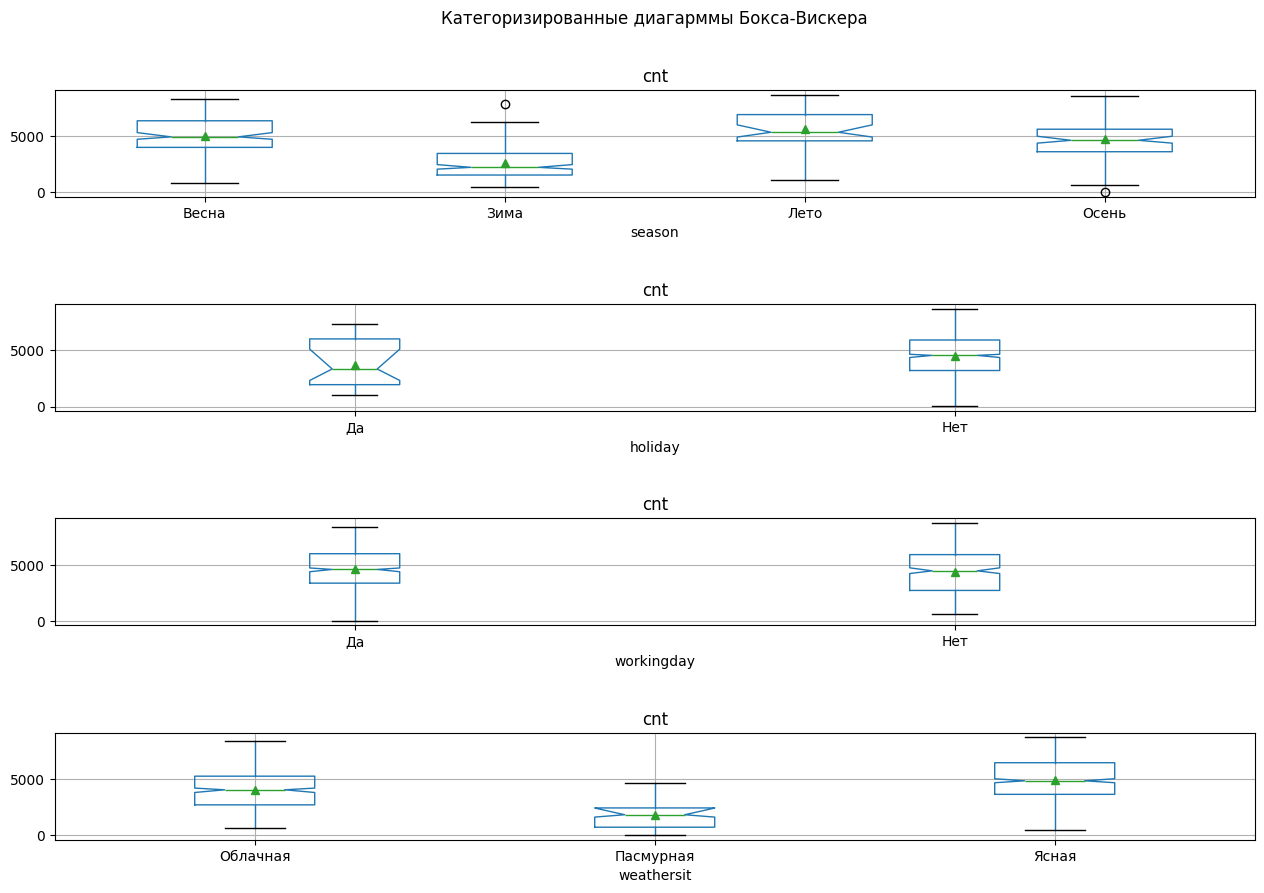

In [164]:
# Отбор имен качественных переменных
cols = bicycles_n.columns
# Количество графиков в столбце
nrow = len(cols) # Количество переменных в cols
fig, ax_lst = plt.subplots(nrow, 1, figsize=(15,10))
for nplt, s in enumerate(cols):
# Доверительные интервалы строятся методом бутстрепа    
    BICYCLES.boxplot(column='cnt', by=s, ax=ax_lst[nplt], grid=True, notch=True, 
                bootstrap=50, showmeans=True, color=None)
    fig.subplots_adjust(wspace=1, hspace=1.0)
# Общая подпись к графикам
fig.suptitle('Категоризированные диагарммы Бокса-Вискера')
plt.savefig('./graphics/bicycles_qqdep.pdf', format='pdf')
plt.show()

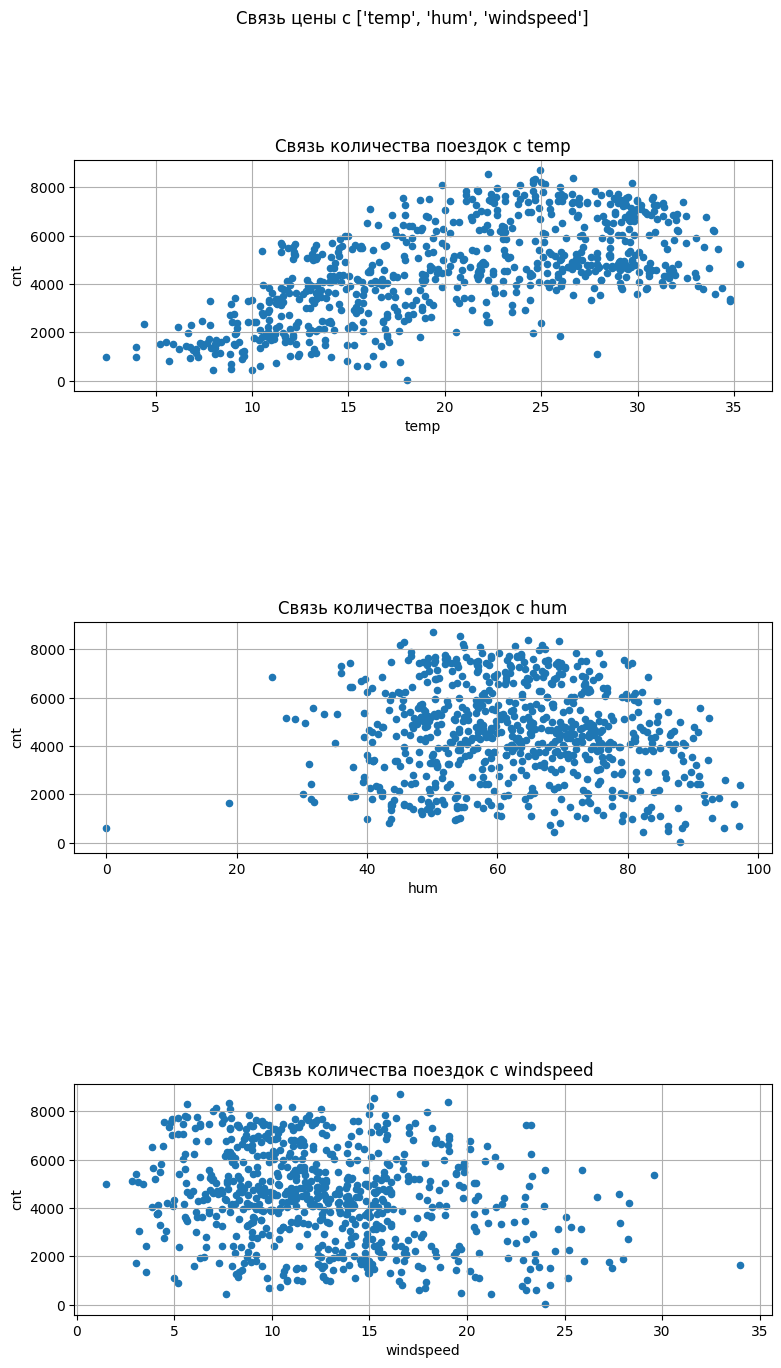

In [165]:
nrow = bicycles_rel.shape[1] - 1 # Учитываем, что одна переменная целевая - ось 'Y'
fig, ax_lst = plt.subplots(nrow, 1, figsize=(9, 15)) 
for nplt, s in enumerate(bicycles_rel.columns[:-1]): # Последняя переменная - целевая ('Y')
    bicycles_rel.plot.scatter(s, 'cnt', ax=ax_lst[nplt])
    ax_lst[nplt].grid(visible=True)
    ax_lst[nplt].set_title(f'Связь количества поездок с {s}')
fig.subplots_adjust(wspace=0.5, hspace=1.0)
"""
Общая подпись к графикам
Используем форматированные 'f'-строки
{} - позиция для подстановки значения
"""
fig.suptitle(f'Связь цены с {list(bicycles_rel.columns[:-1])}')
plt.savefig('./graphics/bicycles_scat.pdf', format='pdf')
plt.show()